### Table of Contents

* [Problem and discretization](#chapter1)
* [Euler explicit](#chapter2)
* [Euler implicit](#chapter3)
* [Runge Kutta 4th Order](#chapter4)
    * [Method implementation](#chapter4_a)
    * [With scipy solver](#chapter4_b)
* [Plot with differents methods](#chapter5)
* [Execution time](#chapter6)

# Lorenz ODE numerical Methods
by AYDOGDU Melissa and LECOURTIER Frédérique

***Lorenz ODE:***
$$\left\{\begin{align} 
    x'&=\sigma(y-x) \\
    y'&=x(r-z)-y \\
    z'&=xy-bz
\end{align}\right.$$

**Tools,  functions :**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import time

In [2]:
def plot_lorenz(num_figure,fct,γ,X0,N,T):
    x,y,z=fct(γ,X0,N,T)
    fig=plt.figure(figsize=(18,5))
    
    #plot 2D x en fonction de y
    ax0 = fig.add_subplot(1,3,1)
    ax0.set_title(str(fct.__name__)+'\n'+num_figure+'\n')
    ax0.plot(x,y)
    
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    
    #plot 2D x en fonction de z
    ax1 = fig.add_subplot(1,3,2)
    ax1.set_title(fr"$\sigma={γ[0]}, b={γ[1]}, r={γ[2]},$" +'\n'+ fr"$X0=({X0[0]}, {X0[1]}, {X0[2]}), N={N}, T={T}$"+'\n')
    ax1.plot(x,z)
    
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    
    #plot 3D
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    ax3.plot(x,y,z)
    ax3.plot(X0[0],X0[1],X0[2],"r.")
    
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("z")
    ax3.view_init(28,-95)
    return x,y,z

## Problem and discretization <a class="anchor" id="chapter1"></a>

We consider $f : [0; T] \times \mathbb{R}^n \rightarrow \mathbb{R}^n$ a continuous function. For $X_0\in \mathbb{R}^n$, the problem is to find  $X\in C^1([0,T],\mathbb{R}^n)$ a solution for the differential equation:
	
$$\left\{\begin{aligned}
    X'&=f(t,X) \\
    X(0)&=X_0
\end{aligned}\right.$$

To solve the Lorenz problem we will have:

$$X'=\begin{pmatrix}
    x' \\
    y' \\
    z'
\end{pmatrix}, \quad X=\begin{pmatrix}
    x \\
    y \\
    z
\end{pmatrix} \quad et \quad f(t,X)=\begin{pmatrix}
    \sigma(y-x) \\
    x(r-z)-y \\
    xy-bz
\end{pmatrix}$$

Then, we will use the finite difference method. We will start by slicing the interval $[0,T]$ in $N+1$ discretization points (so $N$ intervals). Let $t_n=n\Delta t$ the discretization timed with $\Delta t=T/N$ the time step. Then, we denote by $X_n=X(t_n)$ the discretization points. So for $n=\{0,\dots,N\}$, we will have:
	
$$\left\{\begin{aligned} 
    x_n&=x(t_n)=x(n\Delta t) \\
    y_n&=y(t_n)=y(n\Delta t) \\
    z_n&=z(t_n)=z(n\Delta t)
\end{aligned}\right.$$

By Taylor's theorem, we get :

$$\begin{aligned}
    &&X(t+\Delta t)&=X(t)+\Delta t X'(t) + O(\Delta t^2) \\
    \Rightarrow&& \quad X'(t)&=\frac{X(t+\Delta t)-X(t)}{\Delta t} + O(\Delta t) \\
    \Rightarrow&& \quad \partial_t X_n&\approx\frac{X_{n+1}-X_n}{\Delta t} \\
\end{aligned}
$$	

## Euler explicit <a class="anchor" id="chapter2"></a>

* simple
* stable condition number(does not increase the approximation errors only if $\Delta t$ is small enough)
* $O(\Delta t)$ global error

The explicit Euler method is written :

$$X_{n+1}=X_n+\Delta t f(t_n,X_n)$$

which will give us:

$$\left\{\begin{align} 
    x_{n+1}&=\sigma\Delta t y_n+(1-\sigma\Delta t) x_n \\
    y_{n+1}&=\Delta t x_n(r-z_n)(1-\Delta t)y_n \\
    z_{n+1}&=\Delta t x_ny_n+(1-b\Delta t)z_n
\end{align}\right.$$

In [3]:
def euler_explicit(γ,X0,N,T): #on a N+1 points de discrétisation
    (σ,b,r)=γ
    (x0,y0,z0)=X0
    dt=T/N
    x=[x0]
    y=[y0]
    z=[z0]
    for n in range(1,N+1):
        x.append(σ*dt*y[n-1]+(1-σ*dt)*x[n-1])
        y.append(dt*x[n-1]*(r-z[n-1])+(1-dt)*y[n-1])
        z.append(dt*x[n-1]*y[n-1]+(1-dt*b)*z[n-1])
    return x,y,z

## Euler implicit <a class="anchor" id="chapter3"></a>

* stable
* $O(\Delta t)$ (less than RK4)

The implicit Euler method is written :

$$X_{n+1}=X_n+\Delta t f(t_{n+1},X_{n+1})$$

which will give us:

$$\left\{\begin{align} 
    x_{n+1}&=x_n+\Delta t\sigma(y_{n+1}-x_{n+1}) \\
    y_{n+1}&=y_n+\Delta t x_{n+1}(r-z_{n+1})-y_{n+1} \\
    z_{n+1}&=z_n+\Delta tx_{n+1}y_{n+1}-\Delta tbz_{n+1}
\end{align}\right.$$


* First, we isolate the $n+1$ terms on the left and the $n$ terms on the right:

$$\left\{\begin{align} 
    (1+\Delta t\sigma)x_{n+1}-\Delta t\sigma y_{n+1}&=x_n \\
    -\Delta t(r-z_{n+1})x_{n+1}+(1+\Delta t)y_{n+1}&=y_n \\
    -\Delta ty_{n+1}x_{n+1}+(1+\Delta tb)z_{n+1}&=z_n
\end{align}\right.$$

* We can then linearize the terms $ \quad x_{n+1}y_{n+1}\approx x_{n+1,k+1}y_{n+1,k} \quad $ and $\quad x_{n+1}z_{n+1}\approx x_{n+1,k+1}z_{n+1,k},\quad $then we get :

$$\left\{\begin{align} 
    (1+\Delta t\sigma)x_{n+1,k+1}-\Delta t\sigma y_{n+1,k+1}&=x_n \\
    -\Delta t(r-z_{n+1,k})x_{n+1,k+1}+(1+\Delta t)y_{n+1,k+1}&=y_n \\
    -\Delta ty_{n+1,k}x_{n+1,k+1}+(1+\Delta tb)z_{n+1,k+1}&=z_n
\end{align}\right.$$

* We can then put in matrix form  $M(X_{n+1,k})X_{n+1,k+1}=X_n$ with :

$$M(X_{n+1,k})=\begin{pmatrix}
    1+\Delta t\sigma & -\Delta t\sigma & 0 \\
    -\Delta t(r-z_{n+1,k}) & 1+\Delta t & 0 \\
    -\Delta ty_{n+1,k} & 0 & 1+\Delta tb
\end{pmatrix}, \quad X_{n+1,k+1}=\begin{pmatrix}
    x_{n+1,k+1} \\
    y_{n+1,k+1} \\
    z_{n+1,k+1}
\end{pmatrix} \quad et \quad X_n=\begin{pmatrix}
    x_n \\
    y_n \\
    z_n
\end{pmatrix} $$

In [4]:
def euler_implicit(γ,X0,N,T): #we have N+1 discretization points
    (σ,b,r)=γ
    (x0,y0,z0)=X0
    dt=T/N

    X = np.zeros( (N+1, len(X0)) )
    X[0] = X0
    
    t=0. #=t_0
    
    for n in range(1,N+1):
        X_kp = X[n-1] #X^{n+1,0}=X^n
        X_k = X_kp + np.ones((len(X0),1))
        k=0
        while np.linalg.norm(X_kp-X_k)/np.linalg.norm(X_k)>1e-5 and k<100:
            X_k = X_kp
            
            M1=np.array([1+dt*σ, -dt*σ, 0])
            M2=np.array([-dt*(r-X_k[2]), 1+dt, 0])
            M3=np.array([-dt*X_k[1], 0, 1+dt*b])
            M=np.stack([M1,M2,M3],axis=0)
            
            X_kp=np.linalg.solve(M,X[n-1])
            k+=1
        X[n]=X_kp
        
    return X[:,0],X[:,1],X[:,2]

## Runge Kutta <a class="anchor" id="chapter4"></a>

### Method implementation <a class="anchor" id="chapter4_a"></a>

* quite simple
* explicit
* $O(\Delta t^4)$ global error -> Much better than explicit Euler

The Runge Kutta method of order 4 is written :

$$X_{n+1}=X_n+\frac{\Delta t}{6}\left(K_1+2K_2+2K_3+K_4\right)$$

where 

$$\left\{\begin{aligned}
    K_1&=f(t_n,X_n) \\
    K_2&=f\left(t_n+\frac{\Delta t}{2},X_n+\frac{1}{2} K_1\Delta t\right) \\
    K_3&=f\left(t_n+\frac{\Delta t}{2},X_n+\frac{1}{2} K_2\Delta t\right) \\
    K_4&=f\left(t_n+\Delta t,X_n+K_3\Delta t\right)
\end{aligned}\right.$$

In [5]:
def f(t_n,X_n,σ, b, r): #X_n=(x_n,y_n,z_n)
    (x,y,z)=X_n
    
    f_1 = σ*(y-x)
    f_2 = x*(r-z)-y
    f_3 = x*y-b*z
    return np.array([f_1,f_2,f_3])

In [6]:
def RK4_Lorenz(γ,X0,N,T): #we have N+1 discretization points
    (σ,b,r)=γ
    
    dt=T/N
    
    X = np.zeros( (N+1, len(X0)) )
    X[0] = X0
    
    t=0. #=t_0
    for n in range(1,N+1):
        K1=f(t, X[n-1],σ,b,r)
        K2=f(t+dt/2., X[n-1] + 1./2. * K1 * dt,σ,b,r)
        K3=f(t+dt/2., X[n-1] + 1./2. * K2 * dt,σ,b,r)
        K4=f(t+dt, X[n-1]+ K3 * dt,σ,b,r)
        
        X[n]=X[n-1]+ dt/6.* (K1+2.*K2+2.*K3+K4)
        t+=dt
        
    return X[:,0],X[:,1],X[:,2]

### With scipy solver <a class="anchor" id="chapter4_b"></a>

$\href{https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp}{link}$

In [7]:
def scipy(γ,X0,N,T):
    t_span=(0.,T)

    X = solve_ivp(f, t_span, X0, args=γ) #method='RK45'
    return X.y[0],X.y[1],X.y[2]

## Plot with differents methods <a class="anchor" id="chapter5"></a>

### Figure 1 :

In [8]:
γ=(10.,8./3,9./10) #(σ,b,r)
X0=(-10.,10.,5.) #(x0,y0,z0)
N=5000
T=100

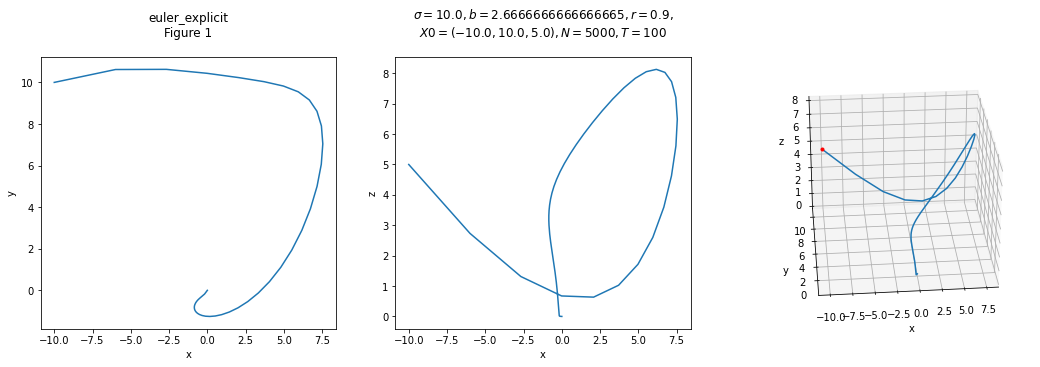

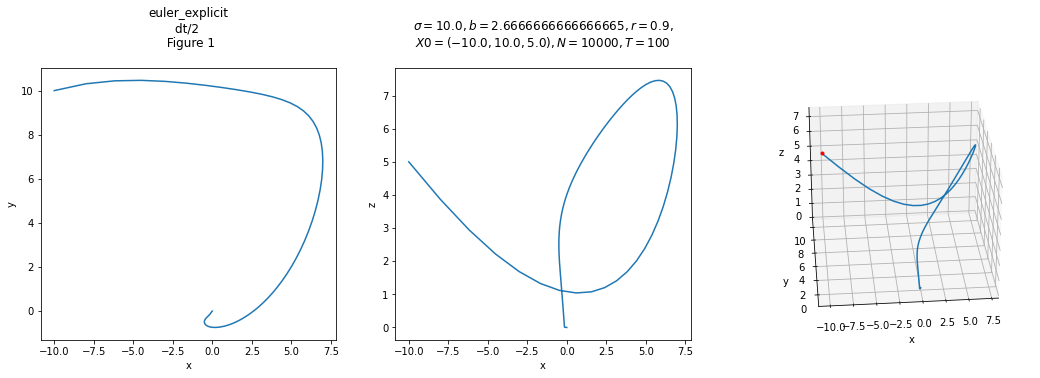

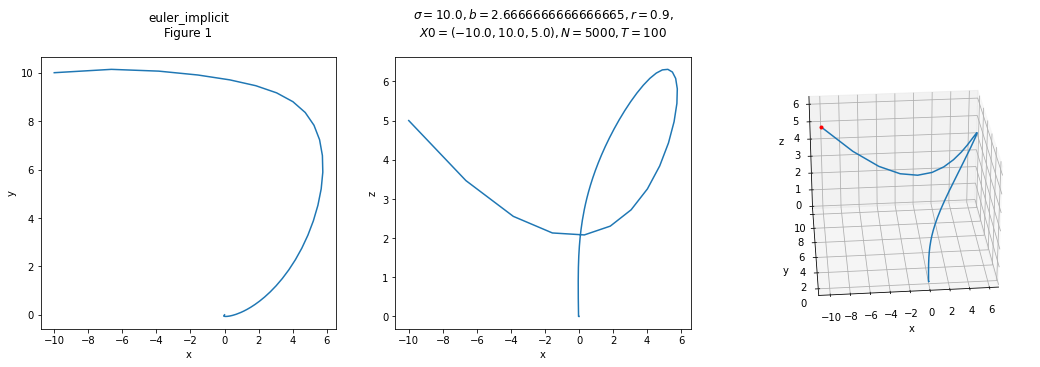

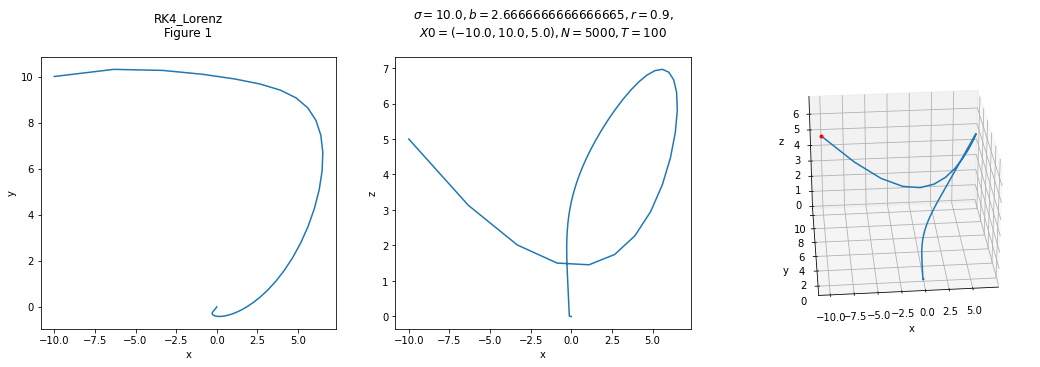

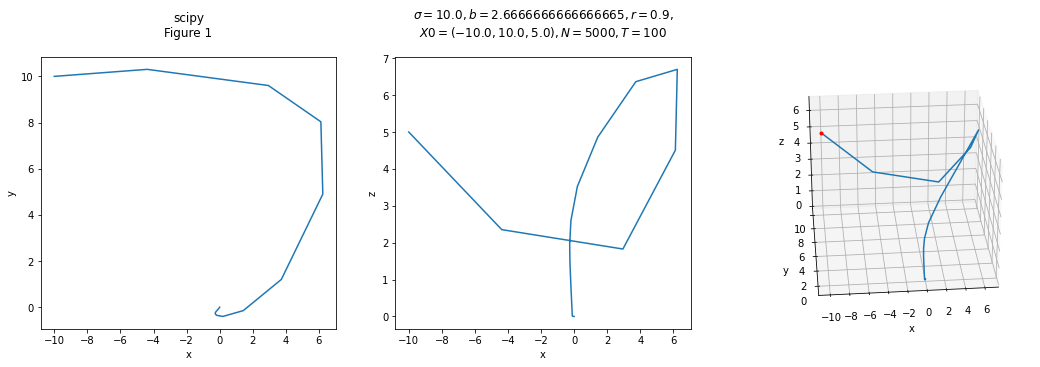

In [9]:
x,y,z=plot_lorenz("Figure 1",euler_explicit,γ,X0,N,T)
pt_final_dt=np.array([x[-1],y[-1],z[-1]])
x,y,z=plot_lorenz("dt/2 \n Figure 1",euler_explicit,γ,X0,2*N,T)
pt_final_dt2=np.array([x[-1],y[-1],z[-1]])
plot_lorenz("Figure 1",euler_implicit,γ,X0,N,T)
plot_lorenz("Figure 1",RK4_Lorenz,γ,X0,N,T)
plot_lorenz("Figure 1",scipy,γ,X0,N,T);

In [10]:
print("Difference bewtween dt and dt/2 for Euler explicit")
print(f"Pt1 with dt={pt_final_dt} \nPt1 with dt/2={pt_final_dt2}\nDifference={abs(pt_final_dt-pt_final_dt2)}\n")

Difference bewtween dt and dt/2 for Euler explicit
Pt1 with dt=[-2.09942003e-05 -2.08017400e-05  1.75847757e-10] 
Pt1 with dt/2=[-1.92661581e-05 -1.90895393e-05  1.48095921e-10]
Difference=[1.72804218e-06 1.71220069e-06 2.77518359e-11]



### Figure 2 :

In [11]:
γ=(10.,8./3,9./10) #(σ,b,r)
X0=(2.,3.,-4.) #(x0,y0,z0)
N=5000
T=100

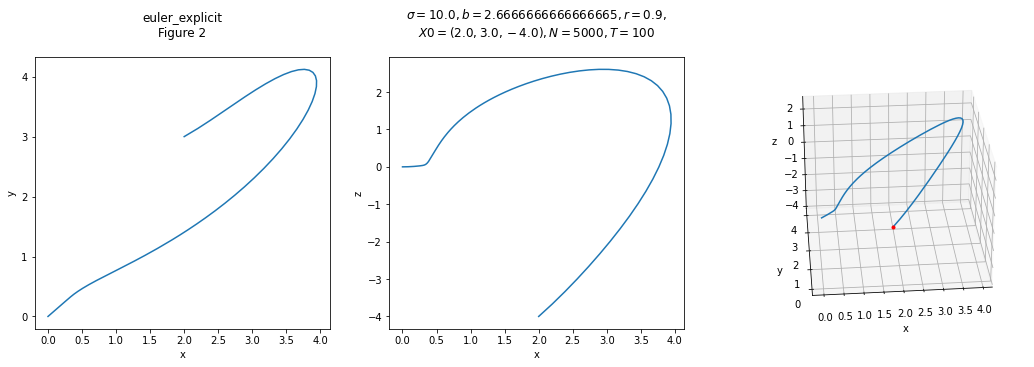

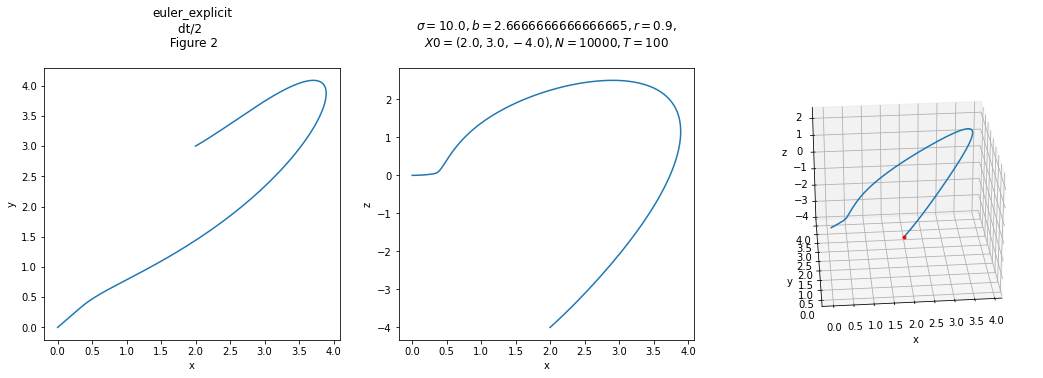

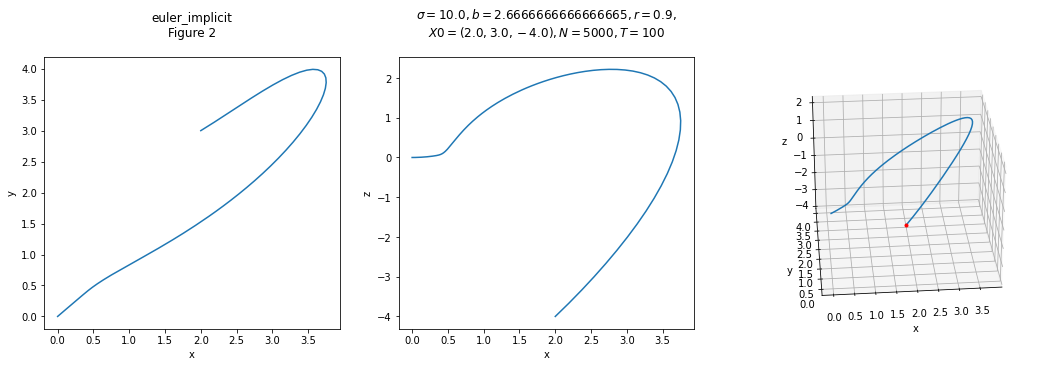

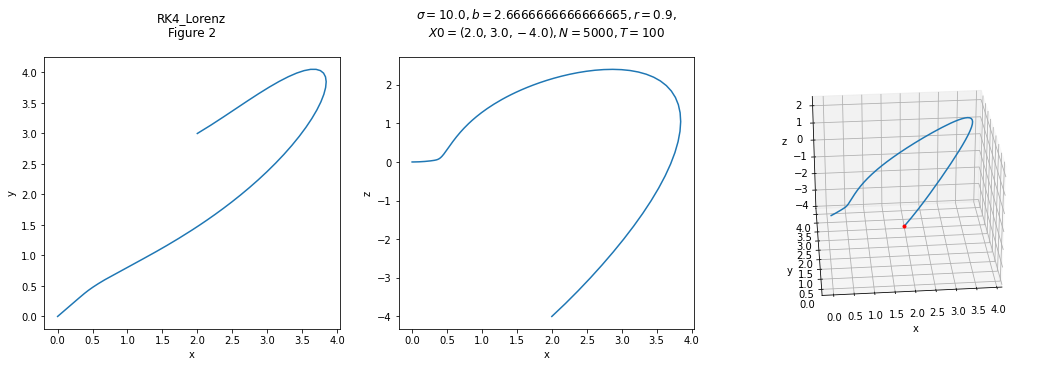

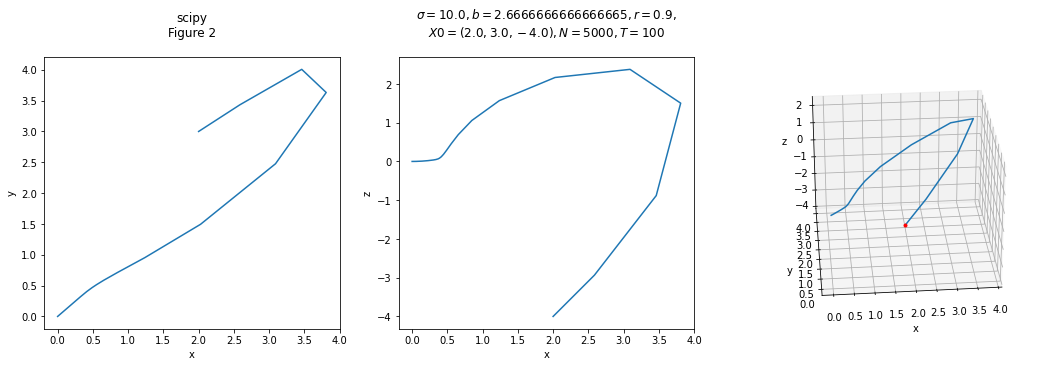

In [12]:
x,y,z=plot_lorenz("Figure 2",euler_explicit,γ,X0,N,T)
pt_final_dt=np.array([x[-1],y[-1],z[-1]])
x,y,z=plot_lorenz("dt/2 \n Figure 2",euler_explicit,γ,X0,2*N,T)
pt_final_dt2=np.array([x[-1],y[-1],z[-1]])
plot_lorenz("Figure 2",euler_implicit,γ,X0,N,T)
plot_lorenz("Figure 2",RK4_Lorenz,γ,X0,N,T)
plot_lorenz("Figure 2",scipy,γ,X0,N,T);

In [13]:
print("Difference bewtween dt and dt/2 for Euler explicit")
print(f"Pt1 with dt={pt_final_dt} \nPt1 with dt/2={pt_final_dt2}\nDifference={abs(pt_final_dt-pt_final_dt2)}\n")

Difference bewtween dt and dt/2 for Euler explicit
Pt1 with dt=[3.64769398e-05 3.61425444e-05 5.30853829e-10] 
Pt1 with dt/2=[3.83221344e-05 3.79708236e-05 5.85938774e-10]
Difference=[1.84519462e-06 1.82827915e-06 5.50849446e-11]



### Figure 3 :

In [14]:
γ=(1.,100.,9./10) #(σ,b,r)
X0=(2.,3.,-4.) #(x0,y0,z0)
N=1000
T=10

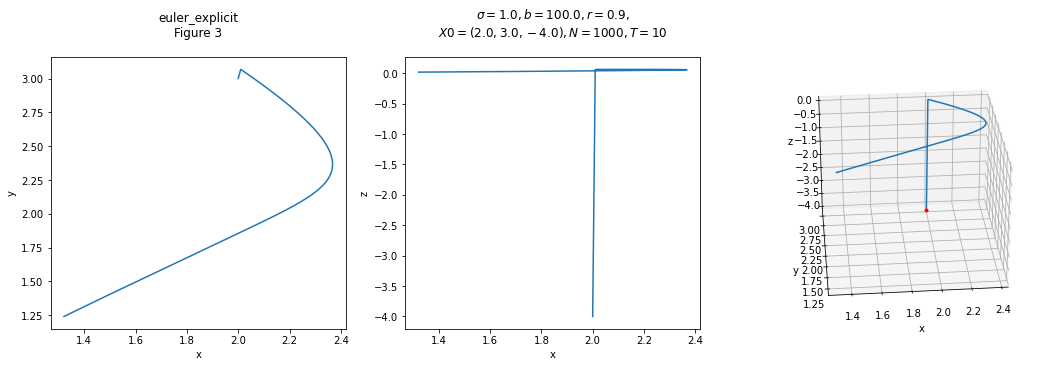

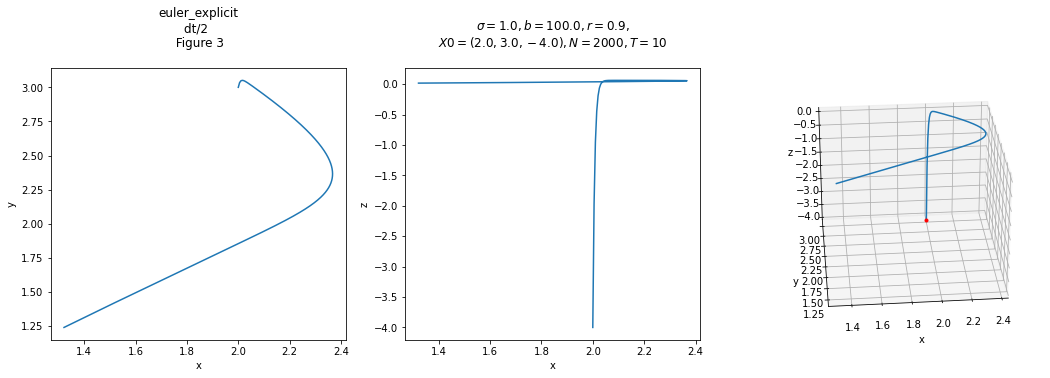

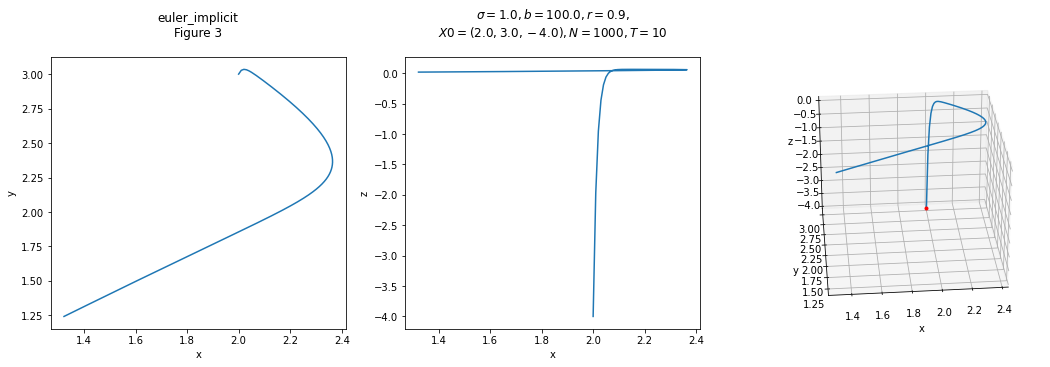

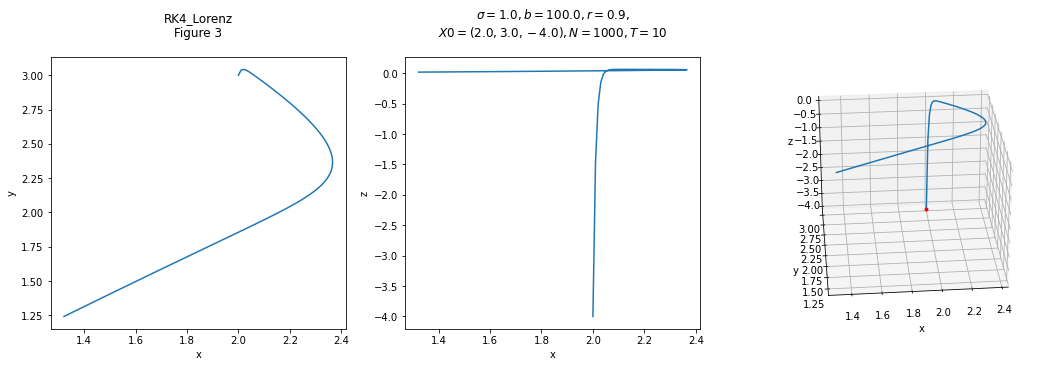

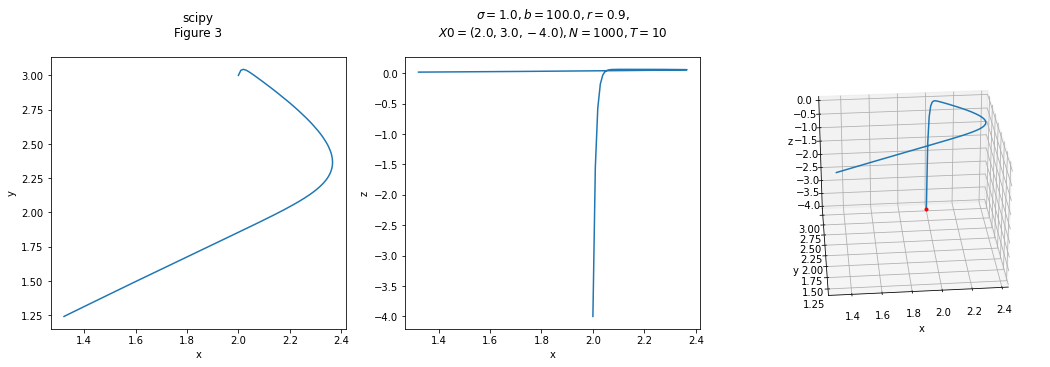

In [15]:
x,y,z=plot_lorenz("Figure 3",euler_explicit,γ,X0,N,T)
pt_final_dt=np.array([x[-1],y[-1],z[-1]])
x,y,z=plot_lorenz("dt/2 \n Figure 3",euler_explicit,γ,X0,2*N,T)
pt_final_dt2=np.array([x[-1],y[-1],z[-1]])
plot_lorenz("Figure 3",euler_implicit,γ,X0,N,T)
plot_lorenz("Figure 3",RK4_Lorenz,γ,X0,N,T)
plot_lorenz("Figure 3",scipy,γ,X0,N,T);

In [16]:
print("Difference bewtween dt and dt/2 for Euler explicit")
print(f"Pt1 with dt={pt_final_dt} \nPt1 with dt/2={pt_final_dt2}\nDifference={abs(pt_final_dt-pt_final_dt2)}\n")

Difference bewtween dt and dt/2 for Euler explicit
Pt1 with dt=[1.32132738 1.24123637 0.0164205 ] 
Pt1 with dt/2=[1.32157471 1.24146367 0.01642659]
Difference=[2.47326214e-04 2.27299693e-04 6.08516638e-06]



### Figure 4 :

In [17]:
γ=(30.,100.,9./10) #(σ,b,r)
X0=(100.,-200.,50.) #(x0,y0,z0)
N=1000
T=0.5

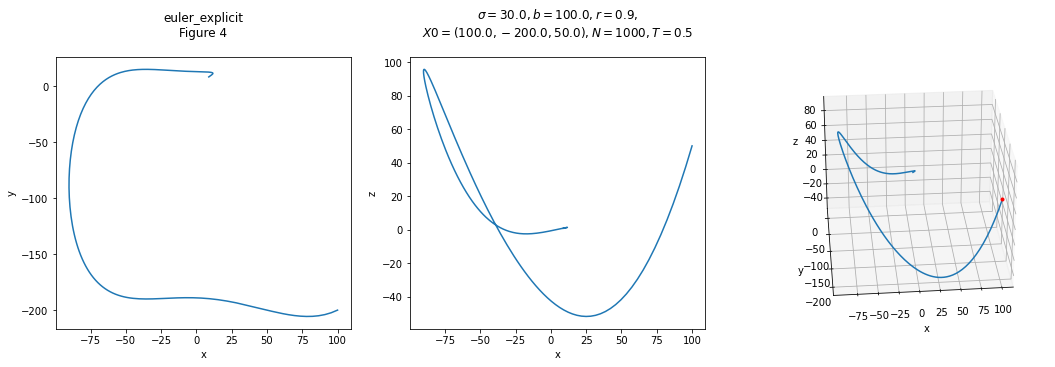

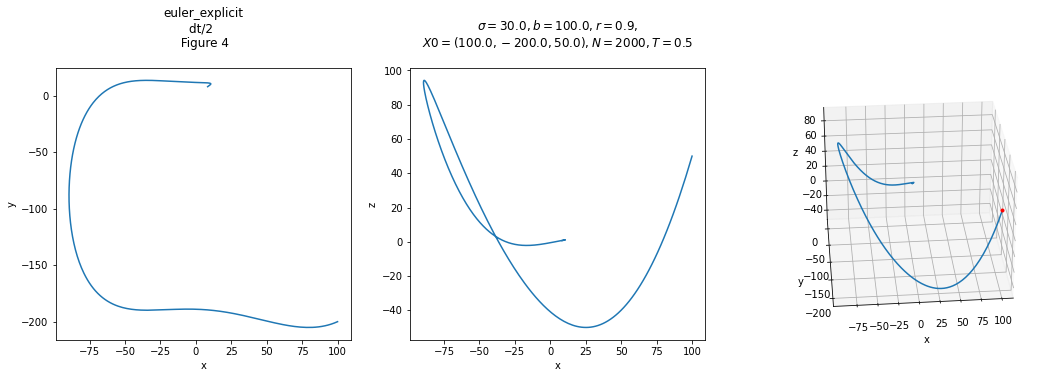

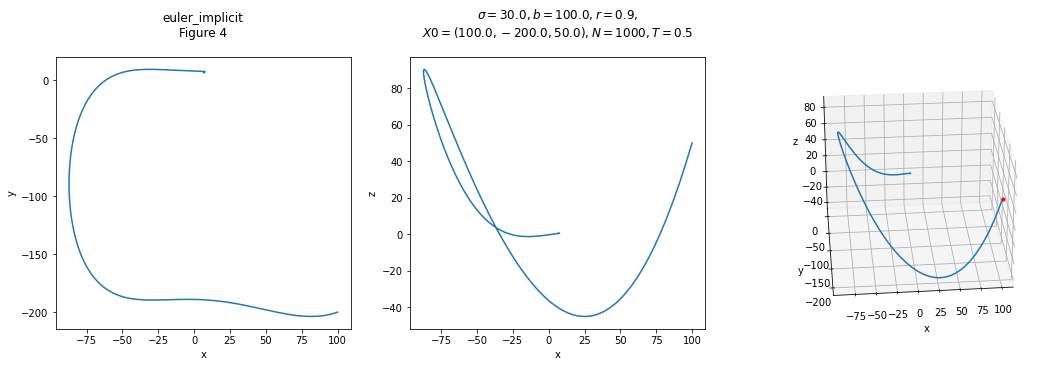

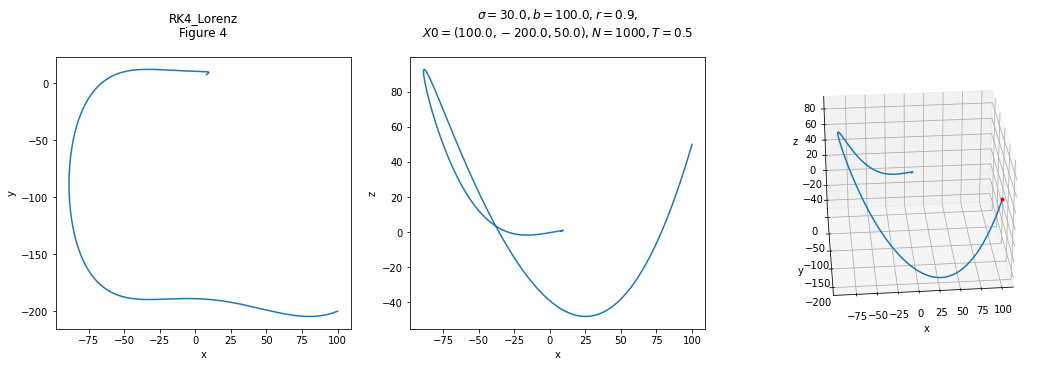

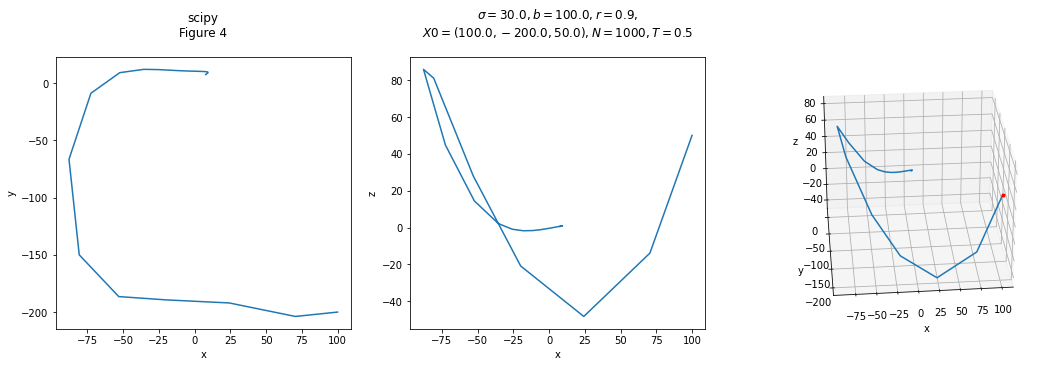

In [18]:
x,y,z=plot_lorenz("Figure 4",euler_explicit,γ,X0,N,T)
pt_final_dt=np.array([x[-1],y[-1],z[-1]])
x,y,z=plot_lorenz("dt/2 \n Figure 4",euler_explicit,γ,X0,2*N,T)
pt_final_dt2=np.array([x[-1],y[-1],z[-1]])
plot_lorenz("Figure 4",euler_implicit,γ,X0,N,T)
plot_lorenz("Figure 4",RK4_Lorenz,γ,X0,N,T)
plot_lorenz("Figure 4",scipy,γ,X0,N,T);

In [19]:
print("Difference bewtween dt and dt/2 for Euler explicit")
print(f"Pt1 with dt={pt_final_dt} \nPt1 with dt/2={pt_final_dt2}\nDifference={abs(pt_final_dt-pt_final_dt2)}\n")

Difference bewtween dt and dt/2 for Euler explicit
Pt1 with dt=[8.78564137 8.51818344 0.76211516] 
Pt1 with dt/2=[8.34212729 8.11244597 0.68798756]
Difference=[0.44351408 0.40573748 0.07412759]



### Figure 5 :

In [20]:
γ=(10.,8./3,28) #(σ,b,r)
X0=(-10.,10.,5.) #(x0,y0,z0)
N=50000
T=100

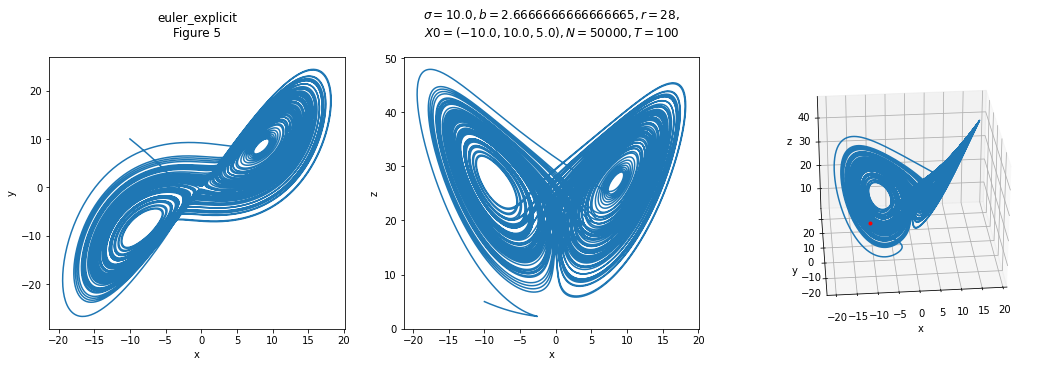

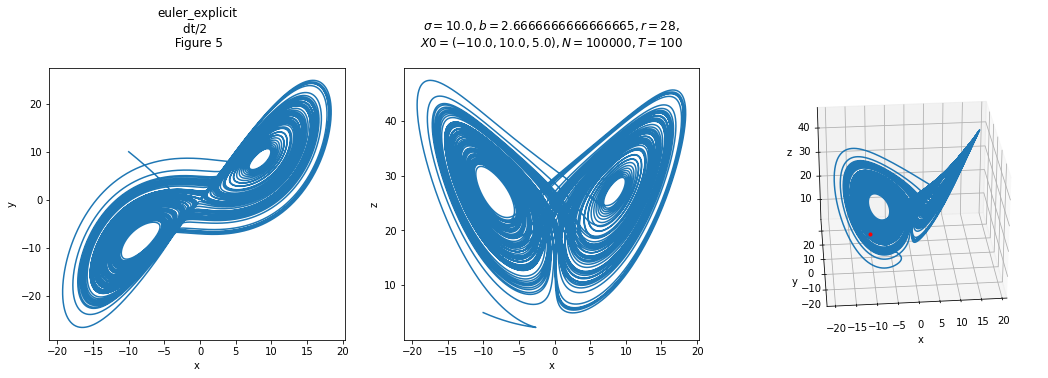

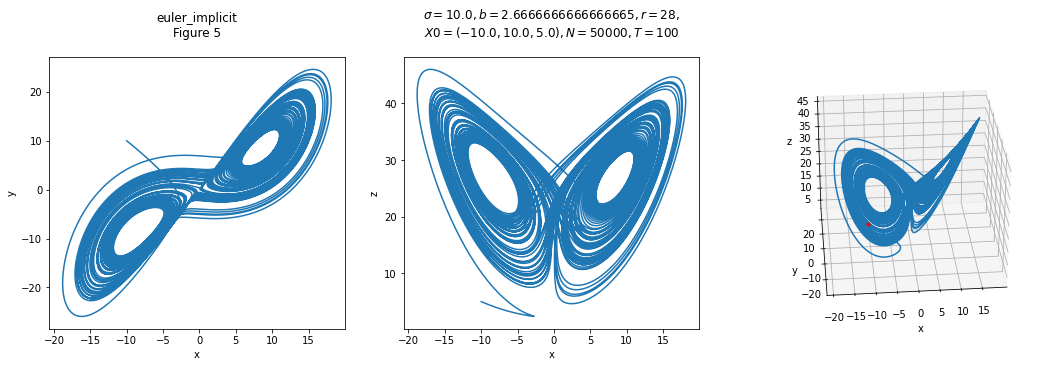

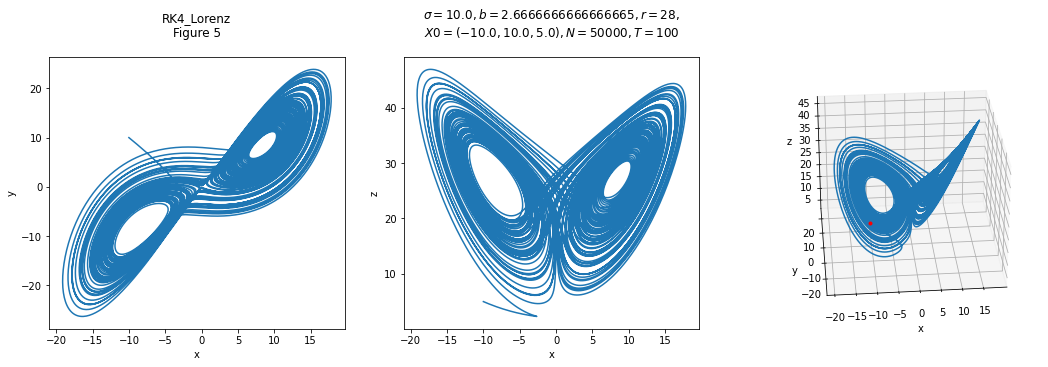

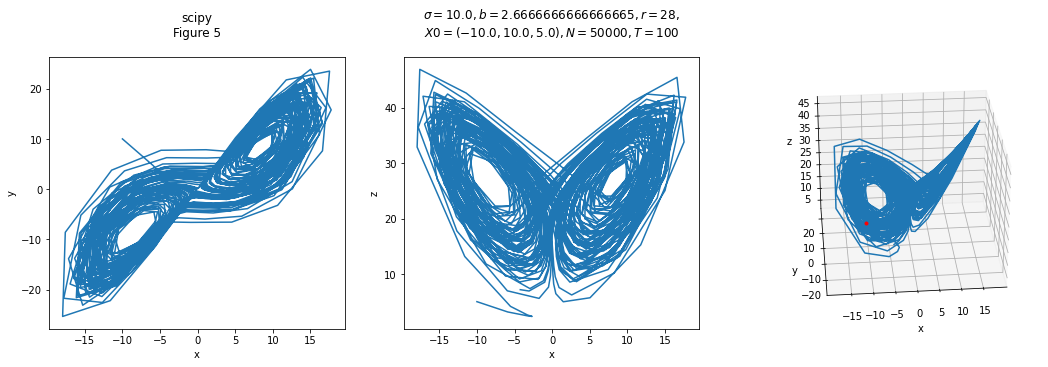

In [21]:
x,y,z=plot_lorenz("Figure 5",euler_explicit,γ,X0,N,T)
pt_final_dt=np.array([x[-1],y[-1],z[-1]])
x,y,z=plot_lorenz("dt/2 \n Figure 5",euler_explicit,γ,X0,2*N,T)
pt_final_dt2=np.array([x[-1],y[-1],z[-1]])
plot_lorenz("Figure 5",euler_implicit,γ,X0,N,T)
plot_lorenz("Figure 5",RK4_Lorenz,γ,X0,N,T)
plot_lorenz("Figure 5",scipy,γ,X0,N,T);

## Execution time <a class="anchor" id="chapter6"></a>

In [22]:
γ=(10.,8./3,9./10) #(σ,b,r)
X0=(-10.,10.,5.) #(x0,y0,z0)
N=5000
T=100

In [23]:
start = time.time()
euler_explicit(γ,X0,N,T)
end = time.time()
print("Execution time for Euler explicit : ",end-start)
start = time.time()
euler_implicit(γ,X0,N,T)
end = time.time()
print("Execution time for Euler implicit : ",end-start)
start = time.time()
RK4_Lorenz(γ,X0,N,T)
end = time.time()
print("Execution time for RK4 implementation : ",end-start)
start = time.time()
scipy(γ,X0,N,T)
end = time.time()
print("Execution time for scipy function : ",end-start)

Execution time for Euler explicit :  0.007096052169799805
Execution time for Euler implicit :  0.5737226009368896
Execution time for RK4 implementation :  0.18490123748779297
Execution time for scipy function :  0.06311321258544922
